In [ ]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.block(x)


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        self.enc1 = DoubleConv(in_channels, 32)
        self.enc2 = DoubleConv(32, 64)
        self.enc3 = DoubleConv(64, 128)
        self.enc4 = DoubleConv(128, 256)

        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(256, 512)

        self.up4 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.dec4 = DoubleConv(256 + 256, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.dec3 = DoubleConv(128 + 128, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec2 = DoubleConv(64 + 64, 64)

        self.up1 = nn.ConvTranspose2d(64, 32, 2, 2)
        self.dec1 = DoubleConv(32 + 32, 32)

        self.out_conv = nn.Conv2d(32, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.up4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.out_conv(d1)


In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet(in_channels=3, out_channels=1).to(device)
model.load_state_dict(torch.load("/content/unet_forecast_kf1to3.pth", map_location=device))
model.eval()

print("Model loaded and ready for inference.")


Model loaded and ready for inference.


In [ ]:
from PIL import Image
import numpy as np

DISP_SCALE = 256.0

def load_raw_disparity(path):
    img = Image.open(path).convert("I")
    arr = np.array(img, dtype=np.float32)
    return arr / DISP_SCALE

def prepare_input(fpaths):
    assert len(fpaths) == 3, "Need exactly 3 frames: [t-2, t-1, t]"
    frames = [load_raw_disparity(p) for p in fpaths]
    arr = np.stack(frames, axis=0)  # [3, H, W]
    tensor = torch.from_numpy(arr).unsqueeze(0)  # [1, 3, H, W]
    return tensor.to(device)


In [ ]:
f1 = "/content/Keyframe2_0.png"   # t-2
f2 = "/content/keyframe2_1.png"   # t-1
f3 = "/content/Keyframe2_2.png"   # t

inp = prepare_input([f1, f2, f3])

with torch.no_grad():
    pred = model(inp)

pred_disp = pred.squeeze().cpu().numpy()

print("Prediction shape:", pred_disp.shape)
print("min/max:", pred_disp.min(), pred_disp.max())


Prediction shape: (1024, 1280)
min/max: 1.5719146 91.344444


In [ ]:
import matplotlib.pyplot as plt

def show_disparities(f_t2, f_t1, f_t, pred_disp, vmin=None, vmax=None):
    """
    Visualize:
    [t-2 | t-1]
    [t   | predicted t+1]
    """
    d_t2 = load_raw_disparity(f_t2)
    d_t1 = load_raw_disparity(f_t1)
    d_t  = load_raw_disparity(f_t)

    if vmin is None:
        vmin = np.nanpercentile(d_t, 5)
    if vmax is None:
        vmax = np.nanpercentile(d_t, 95)

    plt.figure(figsize=(12, 10))

    plt.subplot(2,2,1)
    plt.title("Input t-2")
    plt.imshow(d_t2, cmap='jet', vmin=vmin, vmax=vmax)
    plt.colorbar()

    plt.subplot(2,2,2)
    plt.title("Input t-1")
    plt.imshow(d_t1, cmap='jet', vmin=vmin, vmax=vmax)
    plt.colorbar()

    plt.subplot(2,2,3)
    plt.title("Input t")
    plt.imshow(d_t, cmap='jet', vmin=vmin, vmax=vmax)
    plt.colorbar()

    plt.subplot(2,2,4)
    plt.title("Predicted t+1")
    plt.imshow(pred_disp, cmap='jet', vmin=vmin, vmax=vmax)
    plt.colorbar()

    plt.tight_layout()
    plt.show()


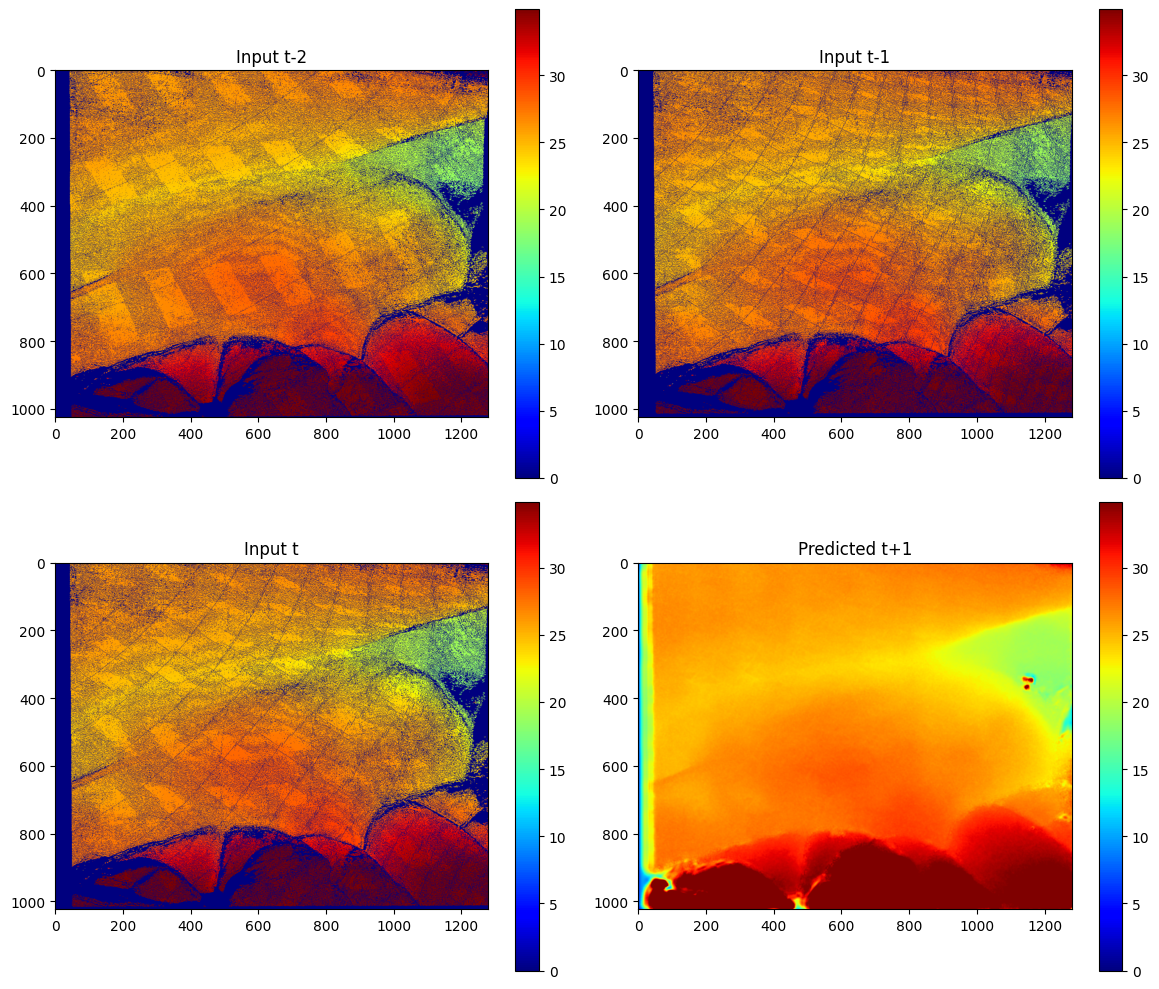

In [ ]:
show_disparities(f1, f2, f3, pred_disp)


In [ ]:
import numpy as np
import matplotlib.cm as cm

def visualize_disparity_raft_style(disp, percentile_range=(5, 95)):
    """
    Applies the SAME visualization as used to generate colored_*.png
    from the original notebook.
    """
    disp = disp.copy()

    invalid = ~np.isfinite(disp) | (disp == 0)
    disp[invalid] = np.nan

    valid = np.isfinite(disp)
    if valid.any():
        vmin, vmax = np.nanpercentile(disp[valid], percentile_range)
    else:
        vmin, vmax = 0.0, 1.0

    norm = np.clip((disp - vmin) / (vmax - vmin + 1e-6), 0, 1)
    norm[np.isnan(norm)] = 0.0

    cmap = cm.get_cmap("turbo")
    color = (cmap(norm)[..., :3] * 255).astype(np.uint8)

    return color


/tmp/ipython-input-3517256164.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("turbo")


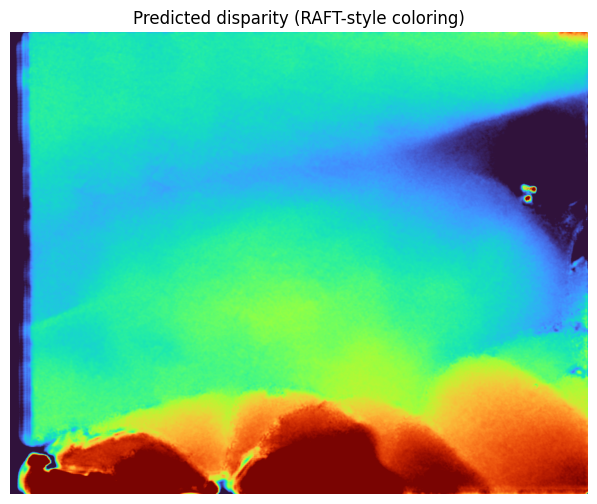

In [ ]:
pred_color = visualize_disparity_raft_style(pred_disp)

plt.figure(figsize=(10,6))
plt.imshow(pred_color)
plt.title("Predicted disparity (RAFT-style coloring)")
plt.axis("off")
plt.show()
